In [48]:
from keras.models import Model, Sequential
from keras import models
import cv2
import numpy as np
from glob import glob
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications import xception


In [49]:
model_path = '../output/model/model_07_26_2022_17_41_18.h5'
model = models.load_model(model_path)
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [64]:
# #masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    #print(f"filepath passed is: {filepath} and full path is: {path}")
    img = image.load_img(filepath, target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

In [77]:
INPUT_SIZE=255
def load_image(img_path, show=False):
    img = read_img(img_path,(INPUT_SIZE,INPUT_SIZE))
    #masking and segmentation
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    output = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    if show:
        plt.imshow(img/255)                           
        plt.axis('off')
        plt.show()

    return output

In [78]:
def decide(model_output):
    if 'flood' in model_output or 'fire' in model_output:
        print("Extreme condition: Find alternative route")
    else:
        print("Normal condition: Proceed")

image path is: ../random_images\ibeju_flood.jpg


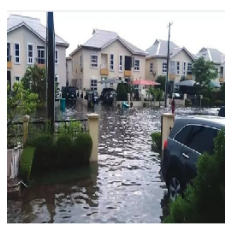

shape of img is: (1, 255, 255, 3)
1/1 [==============================] - 2s 2s/step
[2.6902637e-05 6.8128002e-01 3.1869307e-01] 
[1]
['flood']
Extreme condition: Find alternative route


In [84]:
categories = ['fire', 'flood', 'normal']
random_image_dir = '../random_images/'
image_name='ibeju*'

image_path= random_image_dir+image_name
image_path=glob(image_path)[0]

print(f"image path is: {image_path}")

img = load_image(image_path,True)

print(f"shape of img is: {img.shape}")
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
img = xception_bf.predict(img, batch_size=32, verbose=1)
#bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

res = model.predict(img)
for x in res:
    print(f"{x} ")
classes = np.argmax(model.predict(img), axis = -1)

print(classes)

names = [categories[i] for i in classes]

print(names)

decide(names)